### Cluster analysis of board games 

### Business question: How do board games cluster? Which cluster of the board games is the priciest? Which are the most frequent categories in each cluster?

#### Introduction
In this analysis we are going to examine that based on their characteristics which type of board games create separate groups. We used cluster analysis to create group membership and the following features were considered:

* Maximum playtime
* Minimum playing age
* Minimum number of players
* Average learning complexity score

Once we created separate clusters of the board games we examined how the distribution of the prices differ across the clusters. We also examined which categories are the most frequent in each cluster. 

#### What the code contains:

* Join of the exchange rates to convert the prices in foreign currencies to USD
* Cluster analysis using K-means clustering
* Analysis of the price distribution in each cluster
* Analysis of the most frequent board game categories in each cluster

In [1]:
# Import libraries
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib
from itertools import combinations
%matplotlib inline

#### 1. Import dataset
For the analysis we used the cleaned dataset with all the category dummies created in the ratings analysis.

In [2]:
# Import dataset 
board_games = pd.read_csv("board_games_workfile2.csv", sep=';')
pd.options.display.max_columns = None
board_games.head()

,Unnamed: 0,index,game_id_base,max_players_base,max_playtime_base,min_age_base,min_players_base,min_playtime_base,year_published_base,category_base,average_rating_base,users_rated_base,average_learning_complexity_api,average_strategy_complexity_api,min_age_category_base,year_published_category_base,users_rated_log_base,game_id_base_d,economic_d,negotiation_d,political_d,cardgame_d,fantasy_d,abstractstrategy_d,medieval_d,ancient_d,exploration_d,travel_d,farming_d,mythology_d,bluffing_d,sciencefiction_d,collectiblecomponents_d,dice_d,fighting_d,print&play_d,miniatures_d,racing_d,americanwest_d,citybuilding_d,adventure_d,wargame_d,civilization_d,renaissance_d,humor_d,electronic_d,horror_d,novel-based_d,territorybuilding_d,maze_d,puzzle_d,real-time_d,partygame_d,aviation/flight_d,worldwarii_d,americancivilwar_d,ageofreason_d,worldwari_d,animals_d,childrensgame_d,nautical_d,pirates_d,murder/mystery_d,transportation_d,prehistoric_d,deduction_d,trains_d,industry/manufacturing_d,action/dexterity_d,sports_d,gamesystem_d,wordgame_d,spies/secretagents_d,educational_d,medical_d,mafia_d,zombies_d,comicbook/strip_d,civilwar_d,spaceexploration_d,americanindianwars_d,americanrevolutionarywar_d,napoleonic_d,post-napoleonic_d,book_d,movies/tv/radiotheme_d,arabian_d,memory_d,modernwarfare_d,environmental_d,number_d,religious_d,music_d,trivia_d,pikeandshot_d,videogametheme_d,math_d,vietnamwar_d,mature/adult_d,koreanwar_d,expansionforbase-game_d,price_api,price_ca_api,price_uk_api,price_au_api,discount_api,listing_clicks_api
0,0,0,1,5,240,14,3,240,1986,"Economic,Negotiation,Political",7.66508,4498,0.0,0.0,13-17,1981-1990,8.411388,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0
1,1,1,2,4,30,12,3,30,1981,"Card Game,Fantasy",6.60815,478,0.0,0.0,8-12,1981-1990,6.169611,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.99,0.00,0.0,0.00,0.0,0
2,2,4,3,4,60,10,2,30,1998,"Abstract Strategy,Medieval",7.44119,12019,0.0,0.0,8-12,1991-2000,9.394244,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0
3,3,7,4,4,60,12,2,60,1992,Ancient,6.60675,314,0.0,0.0,8-12,1991-2000,5.749393,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0
4,4,8,5,6,90,12,3,90,1964,Economic,7.35830,15195,0.0,0.0,8-12,1961-1970,9.628722,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.99,40.49,0.0,49.99,-1.0,8


#### 2. Convert prices in foreign currency to USD

The price of the board games (in USD) was not filled for almost half of the observations. In order to increase the number of observations we considered the following:

* The API provides 4 price variables in 4 currencies: USD, GBP, AUD, CAD.
* These are not the exchanged prices, but the available prices from different countries.
* We chose as target the USD price, however, where USD was missing but a different currency was provided, we converted it using the latest exchange rate from **forex_python** module.
* Afterwards, we dropped missing prices (we assumed that no board games were free) and a few extremely highly priced games.

In [3]:
sum(board_games['price_api'] == 0)

2722

In [4]:
sum((board_games['price_api'] == 0) & ((board_games['price_ca_api'] != 0) | (
    board_games['price_uk_api'] != 0) | (board_games['price_au_api'] != 0)))

630

In [5]:
# !pip install forex_python

In [6]:
from forex_python.converter import CurrencyRates

c = CurrencyRates()

gbp_usd = c.get_rate('GBP', 'USD' )
cad_usd = c.get_rate('CAD', 'USD')
aud_usd = c.get_rate('AUD', 'USD')

In [7]:
board_games['price_api'] = np.where(board_games['price_api'] == 0 , np.where(board_games['price_ca_api'] != 0 , 
                                                                    round(board_games['price_ca_api'] * cad_usd, 2) ,
                                                                    np.where(board_games['price_uk_api'] != 0 , 
                                                                    round(board_games['price_uk_api'] * gbp_usd, 2) ,
                                                                    np.where(board_games['price_au_api'] != 0 , 
                                                                    round(board_games['price_au_api'] * aud_usd, 2) ,
                                                                    board_games['price_api']))), board_games['price_api'])

With the convertion we could increase the number of valid observations by 630.

In [8]:
# 2722 - 630 = 2092 
sum(board_games['price_api'] == 0)

2092

Next, we filtered out those board games for which we still did not have valid price information (we also excluded those with higer price than 1000 USD).

In [9]:
# Keep where price is not zero
board_games = board_games[board_games['price_api'] > 0]
board_games = board_games[board_games['price_api'] < 1000]
len(board_games)

3457

The price distribution now looks the following:

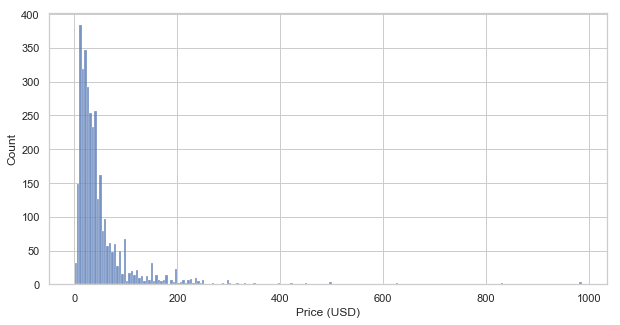

In [10]:
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
sns.histplot(board_games['price_api'])
plt.xlabel("Price (USD)")
plt.show()

There are a some extreme high prices but we kept these observations for further analysis.

#### 3. Cluster analysis

Our goal was to create groups of board games based on their observable characteristicsand. For this, we used the k-means clustering method.

In [11]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter

First we defined the list of variables by which we can create the clusters. For this we only used the continuous features of the board_games. We also excluded the strategic complexity score and the maximum number of players as we could see from the previous EDA that these variables were strongly correlated with the learning complexity score and the minimum number of players respectively.

In [12]:
df=board_games[[
    'min_age_base',
    'min_players_base',
    'min_playtime_base',
    'average_learning_complexity_api']]

We standardized the variables in order to make them easier to compare.

In [13]:
data = scale(df)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


We experimented with different initialization methods and number of clusters in order to create groups of the board games. We tried the following centroid initialization methods:  random data points, k-means++ and principal components.

In [14]:
def fit_kmeans(data, num_clusters, init_method):
    if init_method == 'pca':
        pca = PCA(n_components=num_clusters).fit(data)
        estimator = KMeans(init=pca.components_, n_clusters=num_clusters)
    else:
        estimator = KMeans(init=init_method, n_clusters=num_clusters)
    
    estimator.fit(data)
    return estimator

def print_metrics(data, estimator):
    print('Cluster sizes: ', Counter(estimator.labels_).values())
    
dists_dict = {}

for init_method in ['k-means++','random','pca']:
    print(init_method)
    dists_dict[init_method] = []
    for i in range(2,5):      
        estimator = fit_kmeans(data, i, init_method)
        print_metrics(df,estimator)
        dists_dict[init_method].append(estimator.inertia_)

k-means++
Cluster sizes:  dict_values([1739, 1718])
Cluster sizes:  dict_values([1528, 1619, 310])
Cluster sizes:  dict_values([1302, 1674, 308, 173])
random
Cluster sizes:  dict_values([3139, 318])
Cluster sizes:  dict_values([1528, 1619, 310])
Cluster sizes:  dict_values([1303, 1674, 308, 172])
pca
Cluster sizes:  dict_values([1739, 1718])
Cluster sizes:  dict_values([1528, 1619, 310])
Cluster sizes:  dict_values([553, 1377, 1224, 303])


C:\Users\User\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


 We decided about the method and the number of optimal clusters using the elbow method. Looking at the chart it seems that there is a slight break in the magnitude of the explained variation at 3 cluster using any of the 3 init methods. Therefore we decided to assign the board games to 3 groups. Comparing the goodness of fit across initialization methods we could not see considerable difference between the 3 methods. In order to decide about the init method we also checked the number of observations in each cluster in order to avoid very unbalanced grouping. It seems that with 3 classes the 3 method gives exactly the same clusters so we just chose to assign the cluster memberships from the k-means++ init method. We can also see that there are 2 bigger clusters with around 1600 observations and one smaller group with only about 310 observations.

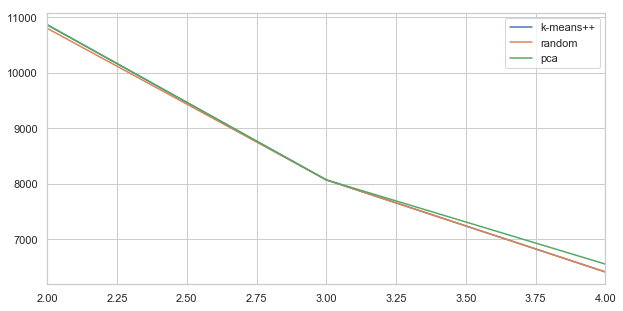

In [15]:
pd.DataFrame(dists_dict).set_index(pd.Index(range(2,5))).plot()

Let's look at the cluster centers to see which type of features characterize the 3 board game groups.

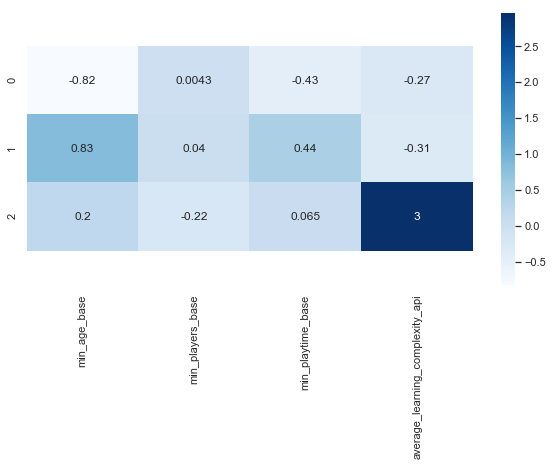

In [16]:
estimator = fit_kmeans(data, 3, 'k-means++')
centers = pd.DataFrame(estimator.cluster_centers_)
centers.columns = df.columns
ax = sns.heatmap(centers, annot=True, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

The following group characteristics were identified:

* Cluster 0 is characterized by long playtime and above average required minimum age. As these games are mainly for more mature audience we can interpret them as 'casual adult games'.
* Cluster 1 is characterized by difficult games that are usually played in small groups. We will label these games as 'hardcore games'.
* Finally, board games in Cluster 2 are short games, avaliable to everyone (the minimum age requirement is below the average). We labelled these games as 'family, party games'.

We can also examine the bivariate plots of the variables to see if we have well separated clusters. We can see that we have quite homogeneous clusters. Especially in the scatterplot of the minimum age and the learning complexity and the scatterplot of the learning complexity and the minimum playtime the board games create well-separated groups.

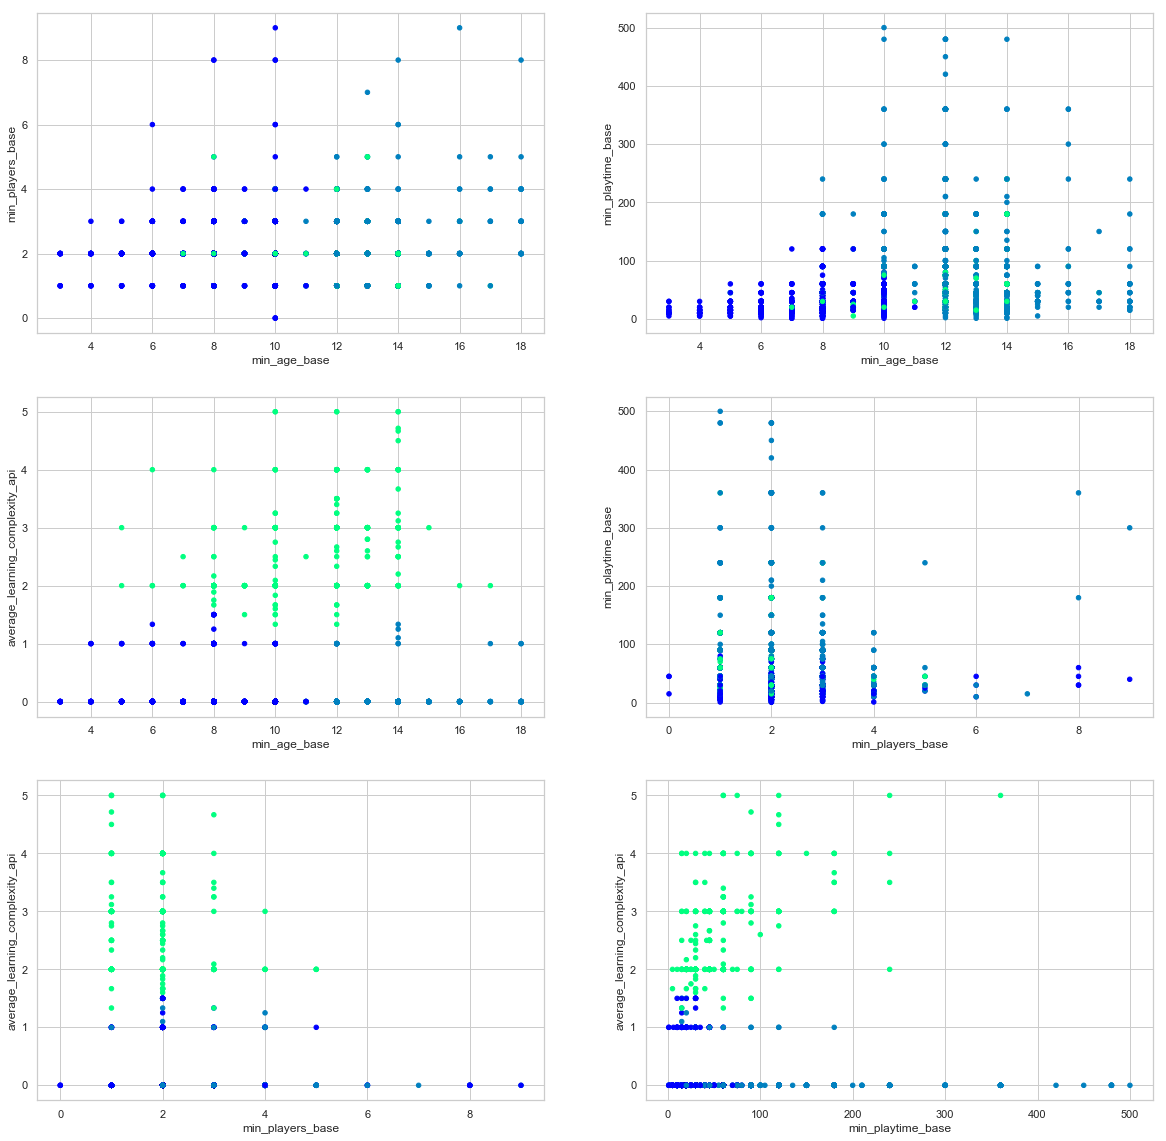

In [17]:
cmap = matplotlib.cm.get_cmap('winter')
xy_toplot = list(combinations(df.columns,2))
fig, axes = plt.subplots(nrows=len(xy_toplot)//2,ncols=2, figsize=(20,20))
i = 0
for x_ax, y_ax in xy_toplot:
    df.plot.scatter(x=x_ax, y=y_ax, c=estimator.labels_, cmap=cmap, ax=axes[i//2, i%2],colorbar=False)
    i += 1
plt.show()

#### 4. Price distribution by clusters

We added the informatioin about the cluster membership to the main dataset to analyze the price distribution in each cluster.

In [18]:
# Save cluster membership
kmeans = fit_kmeans(df, 3, 'k-means++')
board_games['cluster_membership'] = kmeans.labels_

Now let's check what is the pattern of the prices in each cluster. The mean price is the highest in the 'family, party games' cluster while it seems that complex, strategy games are tend to be cheeper. It is not surprising as we can expect that there are many card games in the latter group which are usually less expensive than the classic board games.

In [19]:
board_games_agg = board_games.groupby('cluster_membership').agg({'price_api':'mean'}).rename(columns={'price_api':'Mean price'})
board_games_agg

,Mean price
cluster_membership,
0,79.922099
1,43.903683
2,100.364286


If we look at the distribution of prices we can see that we can encounter with board games with extrem high prices in all 3 clusters.

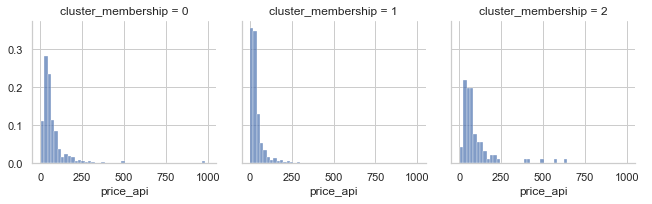

In [20]:
g = sns.FacetGrid(board_games, col="cluster_membership")
g.map(sns.histplot, "price_api", alpha=.7, stat='probability', binwidth = 20)
g.add_legend()

If we only look at those board games that are below 400 USD the difference in the pricing is more visible. In case of the 'complex games' the majority are priced below 50 USD while in case of the 'family&party' and the 'casual adult games' the price ranges between a few dollars and 100 USD. Overall, we can say that the pricing of the games with higher complexity seem to be lower than that of the other two groups.

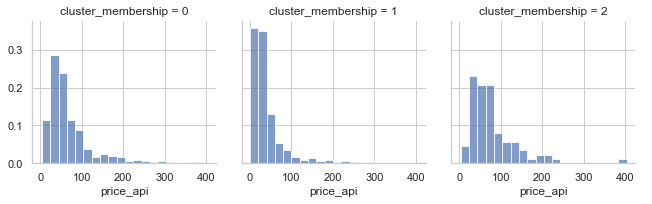

In [21]:
g = sns.FacetGrid(board_games[board_games['price_api']<400], col="cluster_membership")
g.map(sns.histplot, "price_api", alpha=.7, stat='probability', binwidth = 20)
g.add_legend()

#### 5. Most frequent board game categories in the clusters

It is also worth to check that which are the most frequent categories of board games in each cluster. Are they in line with the classification implied by the clustering?

In [22]:
# Most frequent categories in each group
dummies = board_games[board_games.columns[pd.Series(board_games.columns).str.endswith('_d')]]
dummies = dummies.loc[:, ~dummies.columns.isin(['game_id_base_d'])]

dummies["cluster_membership"] = board_games["cluster_membership"]
dummies_grouped = dummies.groupby(['cluster_membership']).sum()
dummies_grouped

,economic_d,negotiation_d,political_d,cardgame_d,fantasy_d,abstractstrategy_d,medieval_d,ancient_d,exploration_d,travel_d,farming_d,mythology_d,bluffing_d,sciencefiction_d,collectiblecomponents_d,dice_d,fighting_d,print&play_d,miniatures_d,racing_d,americanwest_d,citybuilding_d,adventure_d,wargame_d,civilization_d,renaissance_d,humor_d,electronic_d,horror_d,novel-based_d,territorybuilding_d,maze_d,puzzle_d,real-time_d,partygame_d,aviation/flight_d,worldwarii_d,americancivilwar_d,ageofreason_d,worldwari_d,animals_d,childrensgame_d,nautical_d,pirates_d,murder/mystery_d,transportation_d,prehistoric_d,deduction_d,trains_d,industry/manufacturing_d,action/dexterity_d,sports_d,gamesystem_d,wordgame_d,spies/secretagents_d,educational_d,medical_d,mafia_d,zombies_d,comicbook/strip_d,civilwar_d,spaceexploration_d,americanindianwars_d,americanrevolutionarywar_d,napoleonic_d,post-napoleonic_d,book_d,movies/tv/radiotheme_d,arabian_d,memory_d,modernwarfare_d,environmental_d,number_d,religious_d,music_d,trivia_d,pikeandshot_d,videogametheme_d,math_d,vietnamwar_d,mature/adult_d,koreanwar_d,expansionforbase-game_d
cluster_membership,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,172.0,66.0,46.0,56.0,107.0,7.0,56.0,38.0,61.0,6.0,11.0,13.0,27.0,92.0,4.0,27.0,102.0,4.0,45.0,9.0,12.0,51.0,74.0,117.0,51.0,34.0,28.0,3.0,29.0,30.0,54.0,1.0,2.0,4.0,17.0,9.0,32.0,5.0,8.0,2.0,7.0,8.0,30.0,7.0,13.0,45.0,8.0,12.0,29.0,30.0,2.0,8.0,0.0,1.0,7.0,8.0,2.0,4.0,12.0,8.0,7.0,24.0,3.0,3.0,6.0,3.0,2.0,34.0,7.0,1.0,12.0,7.0,3.0,7.0,2.0,13.0,0.0,18.0,3.0,3.0,2.0,1.0,1.0
1,174.0,80.0,53.0,1037.0,412.0,223.0,162.0,105.0,102.0,32.0,41.0,65.0,237.0,222.0,41.0,284.0,237.0,48.0,95.0,93.0,33.0,108.0,135.0,125.0,53.0,46.0,207.0,38.0,111.0,79.0,90.0,31.0,74.0,140.0,307.0,29.0,47.0,7.0,5.0,10.0,201.0,199.0,71.0,56.0,60.0,46.0,28.0,217.0,43.0,44.0,129.0,43.0,3.0,77.0,48.0,55.0,13.0,21.0,51.0,46.0,1.0,43.0,1.0,2.0,3.0,5.0,3.0,137.0,16.0,64.0,12.0,27.0,25.0,19.0,11.0,65.0,0.0,42.0,6.0,1.0,15.0,0.0,3.0
2,17.0,9.0,10.0,2.0,2.0,0.0,3.0,10.0,1.0,0.0,0.0,0.0,2.0,6.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,2.0,2.0,74.0,6.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,26.0,3.0,6.0,5.0,0.0,0.0,6.0,0.0,2.0,6.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,3.0,1.0,0.0,1.0,0.0,0.0,7.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,2.0,1.0,2.0,0.0


In [23]:
# Transpose
dummies_grouped_t = dummies_grouped.T 

**Cluster 0:** In the Cluster 0 that we labelled as  'casual adult games' the most frequent categories are economic, wargame, fantasy, fighting and sci-fi which are usually for more mature audience.

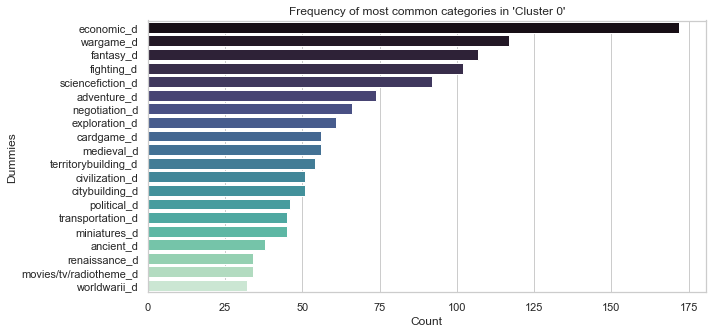

In [24]:
# Create dataframe
dummies1 = pd.DataFrame(dummies_grouped_t[0].sort_values(ascending=False).head(20))
dummies1.reset_index(inplace=True)
dummies1 = dummies1.rename(columns = {'index':'dummy', 0: 'count'})

# Plot
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig = sns.barplot( x='count', y= 'dummy', data=dummies1, palette = "mako")
plt.xlabel("Count")
plt.ylabel("Dummies")
plt.title("Frequency of most common categories in 'Cluster 0'") 
plt.show(fig)

**Cluster 1**: In the Cluster 1 that we labelled as 'hardcore/strategic games' the most frequent categories are the card games, fantasy, dice and bluffing games which obviously have more complex setting. The only outlier category is the 'partygame' which is also common in this group although it does not really fit into the category. 

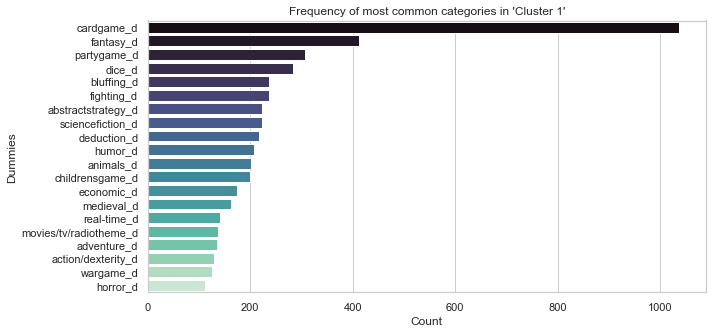

In [25]:
# Create dataframe
dummies2 = pd.DataFrame(dummies_grouped_t[1].sort_values(ascending=False).head(20))
dummies2.reset_index(inplace=True)
dummies2 = dummies2.rename(columns = {'index':'dummy', 1: 'count'})

# Plot
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig = sns.barplot( x='count', y= 'dummy', data=dummies2, palette = "mako")
plt.xlabel("Count")
plt.ylabel("Dummies")
plt.title("Frequency of most common categories in 'Cluster 1'") 
plt.show(fig)


**Cluster 2**: In the Cluster 2 that we labelled as 'family, party games' we can see a quite mixed set of categories. From war and political related board games to economic and sci-fi we can find board games from each category. We also have to note that this category had about one fifth as many board games as the other 2 categories each so the pattern can be due to the limited number of games in this group.

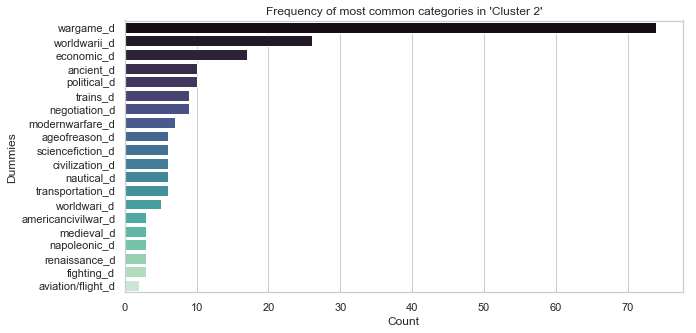

In [26]:
# Create dataframe
dummies3 = pd.DataFrame(dummies_grouped_t[2].sort_values(ascending=False).head(20))
dummies3.reset_index(inplace=True)
dummies3 = dummies3.rename(columns = {'index':'dummy', 2: 'count'})

# Plot
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig = sns.barplot( x='count', y= 'dummy', data=dummies3, palette = "mako")
plt.xlabel("Count")
plt.ylabel("Dummies")
plt.title("Frequency of most common categories in 'Cluster 2'") 
plt.show(fig)


#### 6. Conclusions

In this analysis we examined the how board games cluster based on the length of the playtime, the minimum age requirement, the learning complexity and the minimum number of players required for the game. We found that based on these characteristics three cluster of games can be separated that we labelled as 'casual adult games', 'hardcore/strategic games' and 'family/party games'. When we examined the price distribution of the board games in these three clusters we saw that complex games are the cheepest with an average price of 44 dollars, it is followed by the 'casual adult games' and 'family/party games' are expected to be the most expensive for which we have to pay 100 USD, on average. Regarding the categories of the board games, games which require more learning effort are dominated by card, dice and bluffing games. The 'casual adult games' are related to more general adult topics such as economic, war, sci-fi and fantasy games. On the other hand, for the last cluster we could not see a clear 'mapping' between the group characteristics indicated by the cluster analysis and their actual categorization.   